In [ ]:
# DPD Simulation in 2D with Chain and Ring Molecules
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import copy

# Constants
L = 15.0
rc = 1.0
rho = 4.0
dt = 0.01
steps = 10000
kBT = 0.1111
sigma = 1.0
gamma = 4.5
mass = 1.0
vwall = 5.0
Fbody = 0.3
KS_chain = 100
rS_chain = 0.1
KS_ring = 100
rS_ring = 0.3
np.random.seed(42)

# Conservative force coefficients for chain molecules
conservative_matrix_b = {
    ('A', 'A'): 50, ('A', 'B'): 25, ('A', 'F'): 25, ('A', 'W'): 200,
    ('B', 'A'): 25, ('B', 'B'): 1, ('B', 'F'): 300, ('B', 'W'): 200,
    ('F', 'A'): 25, ('F', 'B'): 300, ('F', 'F'): 25, ('F', 'W'): 200,
    ('W', 'A'): 200, ('W', 'B'): 200, ('W', 'F'): 200, ('W', 'W'): 0
}

# Conservative force coefficients for ring molecules
conservative_matrix_c = {
    ('A', 'A'): 50, ('A', 'F'): 25, ('A', 'W'): 200,
    ('F', 'A'): 25, ('F', 'F'): 25, ('F', 'W'): 200,
    ('W', 'A'): 200, ('W', 'F'): 200, ('W', 'W'): 0
}

In [ ]:
# Particle class
class Particle:
    def __init__(self, position, velocity, ptype, fixed=False):
        self.r = np.array(position)
        self.v = np.array(velocity, dtype=float) # Initialize velocity as a float array
        self.f = np.zeros(2)
        self.ptype = ptype
        self.fixed = fixed

# Bond class
class Bond:
    def __init__(self, i, j, r0, k):
        self.i = i
        self.j = j
        self.r0 = r0
        self.k = k

# Cell list
class CellList:
    def __init__(self, rc, L):
        self.rc = rc
        self.L = L
        self.n_cells = int(L / rc)
        self.cells = [[] for _ in range(self.n_cells ** 2)]

    def get_cell_index(self, pos):
        ix = int(pos[0] / self.rc) % self.n_cells
        iy = int(pos[1] / self.rc) % self.n_cells
        return ix + self.n_cells * iy

    def build(self, particles):
        self.cells = [[] for _ in range(self.n_cells ** 2)]
        for i, p in enumerate(particles):
            idx = self.get_cell_index(p.r)
            self.cells[idx].append(i)

    def neighbors(self, idx, particles):
        p = particles[idx]
        ix = int(p.r[0] / self.rc) % self.n_cells
        iy = int(p.r[1] / self.rc) % self.n_cells
        neigh = []
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                cx = (ix + dx) % self.n_cells
                cy = (iy + dy) % self.n_cells
                cell_idx = cx + self.n_cells * cy
                for j in self.cells[cell_idx]:
                    if j != idx:
                        neigh.append(j)
        return neigh

In [ ]:
# Force computation
def compute_forces(particles, cell_list, bonds, conservative_matrix, apply_body_force=False):
    cell_list.build(particles)
    for p in particles:
        p.f[:] = 0.0
    for i, pi in enumerate(particles):
        for j in cell_list.neighbors(i, particles):
            pj = particles[j]
            rij = pi.r - pj.r
            rij -= L * np.round(rij / L)
            r = np.linalg.norm(rij)
            if r < rc and r > 1e-12:
                eij = rij / r
                vij = pi.v - pj.v
                a = conservative_matrix.get((pi.ptype, pj.ptype), 0.0)
                FC = a * (1 - r / rc) * eij
                wD = (1 - r / rc) ** 2
                FD = -gamma * wD * np.dot(vij, eij) * eij
                wR = (1 - r / rc)
                rand = np.random.normal(0, 1)
                FR = sigma * wR * rand * eij / np.sqrt(dt)
                F = FC + FD + FR
                pi.f += F
                pj.f -= F
    for bond in bonds:
        p1, p2 = particles[bond.i], particles[bond.j]
        rij = p1.r - p2.r
        rij -= L * np.round(rij / L)
        r = np.linalg.norm(rij)
        if r > 1e-12:
            eij = rij / r
            F = bond.k * (1 - r / bond.r0) * eij
            p1.f += F
            p2.f -= F
    if apply_body_force:
        for p in particles:
            if not p.fixed:
                p.f[0] += Fbody

# Velocity-Verlet
def velocity_verlet(particles, bonds, conservative_matrix, apply_body_force=False):
    for p in particles:
        if not p.fixed:
            p.v += 0.5 * dt * p.f / mass
            p.r += dt * p.v
            p.r %= L
            if p.ptype == 'W':
                p.r += dt * p.v
    compute_forces(particles, cell_list, bonds, conservative_matrix, apply_body_force)
    for p in particles:
        if not p.fixed:
            p.v += 0.5 * dt * p.f / mass


In [ ]:
# Generate wall particles
def generate_walls(particles):
    for p in particles:
        if p.r[1] < rc:
            p.ptype = 'W'
            p.fixed = True
            p.v[:] = [-vwall, 0]
        elif p.r[1] > L - rc:
            p.ptype = 'W'
            p.fixed = True
            p.v[:] = [vwall, 0]

# Create chain molecules
particles = []
bonds = []
for _ in range(42):
    x0, y0 = np.random.rand(2) * (L - 2 * rc) + rc
    types = ['A', 'A'] + ['B'] * 5
    idx_start = len(particles)
    for i in range(7):
        particles.append(Particle([x0 + 0.15 * i, y0], [0, 0], types[i]))
        if i > 0:
            bonds.append(Bond(idx_start + i - 1, idx_start + i, rS_chain, KS_chain))

# Add fluid particles
while len(particles) < int(rho * L * L):
    r = np.random.rand(2) * L
    particles.append(Particle(r, [0, 0], 'F'))

generate_walls(particles)
cell_list = CellList(rc, L)

In [ ]:

# Reinitialize
particles = []
bonds = []
all_snapshots = []

for _ in range(10):
    center = np.random.rand(2) * (L - 2 * rc) + rc
    idx_start = len(particles)
    for i in range(9):
        angle = 2 * np.pi * i / 9
        pos = center + 0.3 * np.array([np.cos(angle), np.sin(angle)])
        particles.append(Particle(pos, [0, 0], 'A'))
        if i > 0:
            bonds.append(Bond(idx_start + i - 1, idx_start + i, rS_ring, KS_ring))
    bonds.append(Bond(idx_start + 8, idx_start + 0, rS_ring, KS_ring))
while len(particles) < int(rho * L * L):
    r = np.random.rand(2) * L
    particles.append(Particle(r, [0, 0], 'F'))
generate_walls(particles)
cell_list = CellList(rc, L)
compute_forces(particles, cell_list, bonds, conservative_matrix_c, True)
temps = []
for step in range(steps):
    velocity_verlet(particles, bonds, conservative_matrix_c, True)
    v2 = np.sum([np.dot(p.v, p.v) for p in particles if not p.fixed]) / (2 * len(particles))
    temps.append(v2)
    if step % 500 == 0:
        print(f"[Poiseuille] Step {step}: T = {v2:.4f}")
    # Store state
    all_snapshots.append(copy.deepcopy(particles))


[Poiseuille] Step 0: T = 1.1955
[Poiseuille] Step 500: T = 0.7721
[Poiseuille] Step 1000: T = 1.9243
[Poiseuille] Step 1500: T = 3.3520
[Poiseuille] Step 2000: T = 4.8752
[Poiseuille] Step 2500: T = 6.6061
[Poiseuille] Step 3000: T = 8.3341
[Poiseuille] Step 3500: T = 10.0430
[Poiseuille] Step 4000: T = 11.5767
[Poiseuille] Step 4500: T = 12.8362
[Poiseuille] Step 5000: T = 14.1436
[Poiseuille] Step 5500: T = 15.4147
[Poiseuille] Step 6000: T = 16.3674
[Poiseuille] Step 6500: T = 17.3833
[Poiseuille] Step 7000: T = 18.2089
[Poiseuille] Step 7500: T = 18.8833
[Poiseuille] Step 8000: T = 19.6076
[Poiseuille] Step 8500: T = 20.3512
[Poiseuille] Step 9000: T = 21.1533
[Poiseuille] Step 9500: T = 21.6956


In [ ]:
# Visualization Functions
def plot_particles(particles, step=None):
    color_map = {'A': 'red', 'B': 'orange', 'F': 'blue', 'W': 'black'}
    plt.figure(figsize=(6, 6))
    for p in particles:
        plt.plot(p.r[0], p.r[1], 'o', color=color_map.get(p.ptype, 'gray'), markersize=3)
    plt.xlim(0, L)
    plt.ylim(0, L)
    plt.gca().set_aspect('equal')
    if step is not None:
        plt.title(f"Particle Positions at Step {step}")
    else:
        plt.title("Particle Positions")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.show()

def plot_velocity_profile(particles, nbins=30):
    ys = np.array([p.r[1] for p in particles if p.ptype != 'W'])
    vxs = np.array([p.v[0] for p in particles if p.ptype != 'W'])
    bins = np.linspace(0, L, nbins + 1)
    indices = np.digitize(ys, bins)
    v_profile = np.zeros(nbins)
    counts = np.zeros(nbins)
    for i, vx in zip(indices, vxs):
        if 0 < i <= nbins:
            v_profile[i-1] += vx
            counts[i-1] += 1
    avg_v = np.divide(v_profile, counts, out=np.zeros_like(v_profile), where=counts > 0)
    centers = 0.5 * (bins[:-1] + bins[1:])
    plt.plot(avg_v, centers)
    plt.xlabel("Average vx")
    plt.ylabel("y")
    plt.title("Velocity Profile")
    plt.grid(True)
    plt.show()

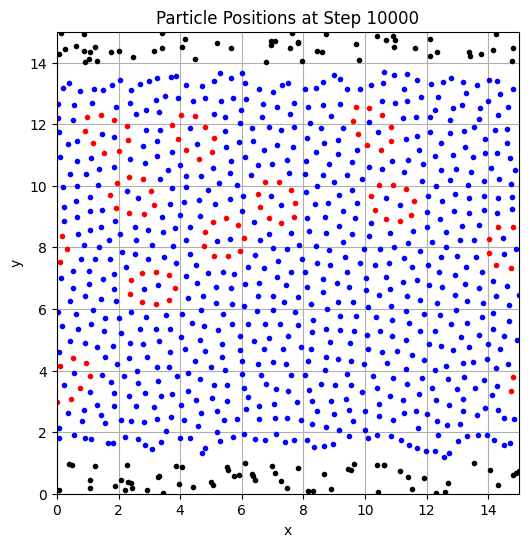

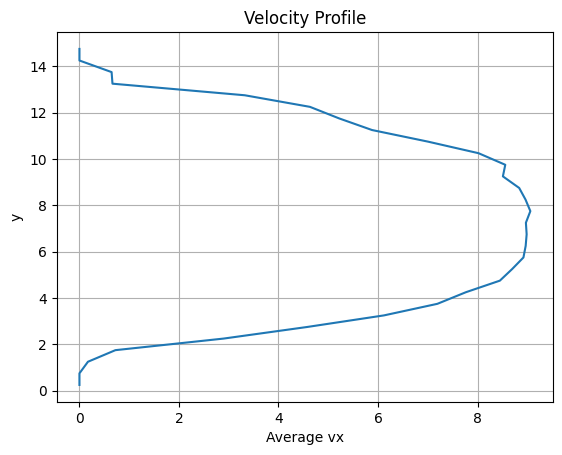

In [ ]:
# Plot particle positions and velocity profile
plot_particles(particles, step=steps)
plot_velocity_profile(particles)